In [29]:
%load_ext autoreload
%autoreload 2

In [24]:
from xgboost import XGBClassifier
text_model = XGBClassifier()
text_model.load_model("models/xgb_text_softprob.json")
summary_100_model = XGBClassifier()
summary_100_model.load_model("models/xgb_summary_100_softprob.json")
summary_50_model = XGBClassifier()
summary_50_model.load_model("models/xgb_summary_50_softprob.json")

In [26]:
import pandas as pd
summary_50_df = pd.read_parquet("df/summary_50_test_df_x.gzip")
summary_100_df = pd.read_parquet("df/summary_100_test_df_x.gzip")
text_df = pd.read_parquet("df/text_test_df_x.gzip")

In [32]:
from utils.experiment_helpers import compare_grouped_feature_importance, compare_within_group_feature_importance

In [35]:
compare_grouped_feature_importance(
    models=[text_model, summary_100_model, summary_50_model],
    group_prefixes={
        "sentiment": "Sentiment",
        "topic": "Tag"
    },
    model_names=["Full Text", "100 Word Summary", "50 Word Summary"],
    importance_type='gain',
    output_dir='plots/feature_group_gain'
)

Full Text
100 Word Summary
50 Word Summary


{'Full Text': {'Text': 1786.8720687627792,
  'Tag': 78.46708473563194,
  'Sentiment': 41.378151178359985},
 '100 Word Summary': {'Text': 2117.311406850815,
  'Tag': 103.46541285514832,
  'Sentiment': 81.84758579730988},
 '50 Word Summary': {'Text': 2152.262711405754,
  'Tag': 105.55551087856293,
  'Sentiment': 84.40316951274872}}

In [57]:
res = compare_within_group_feature_importance(
    models=[text_model, summary_100_model, summary_50_model],
    group_prefix="sentiment",
    model_names=["Full Text", "100 Word Summary", "50 Word Summary"],
    output_dir='plots/within_group_feature_importance',
    importance_type='cover'
)

#res.to_csv("features/sentiments/gain.csv")

In [58]:
sentiments = list(res.index)

In [66]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np

def compute_total_effect_multiclass_per_treatment(
    model: XGBClassifier,
    df: pd.DataFrame,
    treatment_cols: list[str],
    plot_name: str,
    plot_path='plots',
    class_labels=["Left", "Center", "Right"],
    low_q=0.10,
    high_q=0.90,
):
    result = {}

    assert all(f in df.columns for f in model.feature_names_in_), "Mismatch in required feature columns"

    required_features = list(model.feature_names_in_)

    for t_col in treatment_cols:
        df_copy = df[df[t_col] != 0]

        confounders = list(df_copy.columns)
        confounders.remove(t_col)
        
        x_low = -1
        x_high = 1

        features = [t_col] + confounders
        
        df_low = df_copy[features].copy()        
        df_high = df_copy[features].copy()
        
        df_low[t_col] = x_low
        df_high[t_col] = x_high

        X_low = df_low[required_features]
        X_high = df_high[required_features]

        probs_low = model.predict_proba(X_low)
        probs_high = model.predict_proba(X_high)

        TE_diffs = probs_high - probs_low              # shape: (n_samples, n_classes)

        try:
            TE_means = TE_diffs.mean(axis=0)               # mean TE per class
            TE_q25 = np.percentile(TE_diffs, 25, axis=0)
            TE_q75 = np.percentile(TE_diffs, 75, axis=0)

            result[t_col] = {
                "mean": dict(zip(class_labels, TE_means)),
                "q25": dict(zip(class_labels, TE_q25)),
                "q75": dict(zip(class_labels, TE_q75))
            }
        except:
            print(f"error on column = ", t_col)
            continue

    plot_path = f"{plot_path}/{plot_name}.png"
    x = np.arange(len(class_labels))
    width = 0.8 / len(treatment_cols)

    plt.figure(figsize=(10, 6))
    for i, t_col in enumerate(treatment_cols):
        offsets = x + (i - len(treatment_cols)/2) * width + width/2
        means = [result[t_col]["mean"][cls] for cls in class_labels]
        errs_lower = []
        errs_upper = []

        for cls in class_labels:
            mean = result[t_col]["mean"][cls]
            q25 = result[t_col]["q25"][cls]
            q75 = result[t_col]["q75"][cls]

            err_low = mean - q25
            err_high = q75 - mean

            if err_low < 0:
                print(f"[Warning] Lower whisker negative for class '{cls}' and treatment '{t_col}'. Clipped to 0.")
                err_low = 0.0
            if err_high < 0:
                print(f"[Warning] Upper whisker negative for class '{cls}' and treatment '{t_col}'. Clipped to 0.")
                err_high = 0.0

            errs_lower.append(err_low)
            errs_upper.append(err_high)

        yerr = [errs_lower, errs_upper]

        plt.bar(offsets, means, width=width, yerr=yerr, capsize=4, label=t_col)

    plt.xticks(x, class_labels)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f"Total Effect of Each Treatment (-1 → +1)")
    plt.ylabel("Mean Δ Predicted Probability (with IQR whiskers)")
    plt.legend(title="Treatment", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig(plot_path)
    plt.close()


    return result


/var/folders/fz/y03qr7rx39zcncb4x6fsnclm0000gn/T/ipykernel_4859/576669214.py:49: RuntimeWarning: Mean of empty slice.
  TE_means = TE_diffs.mean(axis=0)               # mean TE per class
/opt/homebrew/anaconda3/envs/conda_env/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


error on column =  sentiment Election 2012


KeyError: 'sentiment Election 2012'

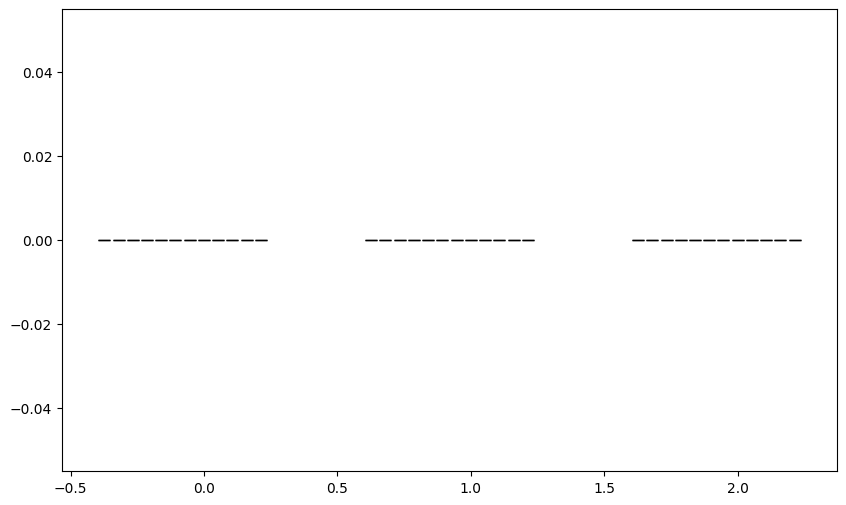

In [67]:
compute_total_effect_multiclass_per_treatment(
    model=text_model,
    df=text_df,
    treatment_cols=sentiments,
    plot_name="TE_top_sentiments_cover_text",
    plot_path="plots/TE_calculations"
)
compute_total_effect_multiclass_per_treatment(
    model=summary_100_model,
    df=summary_100_df,
    treatment_cols=sentiments,
    plot_name="TE_top_sentiments_cover_summary_100",
    plot_path="plots/TE_calculations"
)
compute_total_effect_multiclass_per_treatment(
    model=summary_50_model,
    df=summary_50_df,
    treatment_cols=sentiments,
    plot_name="TE_top_sentiments_cover_summary_50",
    plot_path="plots/TE_calculations"
)

res